In [ ]:
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

import numpy as np

In [19]:

def load_data(file_path):
    with open(file_path) as f:
        data = json.load(f)
        return pd.json_normalize(data)

route = "../lighthouse/results/"
files = {
    "react_desktop": route + "react_desktop/dashboard/results.json",
    "vue_desktop": route + "vue_desktop/dashboard/results.json",
    "react_mobile": route + "react_mobile/dashboard/results.json",
    "vue_mobile": route + "vue_mobile/dashboard/results.json"
}

dataframes = {name: load_data(path) for name, path in files.items()}
dataframes["react_desktop"].head()
# dataframes["vue_desktop"].head()
# dataframes["react_mobile"].head()
# dataframes["vue_mobile"].head()

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift,metrics.speedIndex
0,0.99,603.552,820.444,635.178,0.0,0.000138,674
1,0.99,585.655,852.502,635.487,0.0,0.000138,686
2,0.99,629.469,864.334,653.603,0.0,0.000138,693
3,0.99,631.118,831.773,670.425,0.0,0.000138,703
4,0.99,593.918,810.581,624.524,0.0,0.000138,665


In [20]:
if not os.path.exists("excel"):
    os.makedirs("excel")

output_file = "excel/dataframes_output.xlsx"

with pd.ExcelWriter(output_file) as writer:
    for dataset_name, df in dataframes.items():
        df.to_excel(writer, sheet_name=dataset_name)

print(f"Dataframes saved to {output_file}")

Dataframes saved to excel/dataframes_output.xlsx


In [21]:
dataframes["react_desktop"].head()

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift,metrics.speedIndex
0,0.99,603.552,820.444,635.178,0.0,0.000138,674
1,0.99,585.655,852.502,635.487,0.0,0.000138,686
2,0.99,629.469,864.334,653.603,0.0,0.000138,693
3,0.99,631.118,831.773,670.425,0.0,0.000138,703
4,0.99,593.918,810.581,624.524,0.0,0.000138,665


In [22]:

# Normalize metrics, with min-max normalization
def normalize_metrics(df):
    metrics_to_normalize = ["metrics.firstContentfulPaint", "metrics.largestContentfulPaint",
                            "metrics.timeToInteractive", "metrics.totalBlockingTime", 
                            "metrics.cumulativeLayoutShift", "metrics.speedIndex"]

    for metric in metrics_to_normalize:
        min_val = df[metric].min()
        max_val = df[metric].max()
        # Avoid division by zero 
        if max_val != min_val:
            df[metric] = (df[metric] - min_val) / (max_val - min_val)
        else:
            df[metric] = 0  

    return df

dataframes_normalized = {name: normalize_metrics(df.copy()) for name, df in dataframes.items()}


In [23]:
dataframes_normalized["react_desktop"].head()
#dataframes_normalized["vue_desktop"].head()

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift,metrics.speedIndex
0,0.99,0.081420,0.079301,0.100117,0.0,0,0.099727
1,0.99,0.056268,0.123313,0.100541,0.0,0,0.116120
2,0.99,0.117845,0.139557,0.125393,0.0,0,0.125683
3,0.99,0.120162,0.094854,0.148469,0.0,0,0.139344
4,0.99,0.067881,0.065760,0.085502,0.0,0,0.087432


In [24]:
# Detect outliers using the IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    return outliers

outliers = {name: {col: detect_outliers(df, col) for col in df.columns if "metrics" in col} for name, df in dataframes.items()}

outliers["react_desktop"]["metrics.firstContentfulPaint"]
#outliers["react_desktop"]["metrics.largestContentfulPaint"]


,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift,metrics.speedIndex
12,0.91,1257.148,1491.072,1291.169,0.0,0.000138,1333


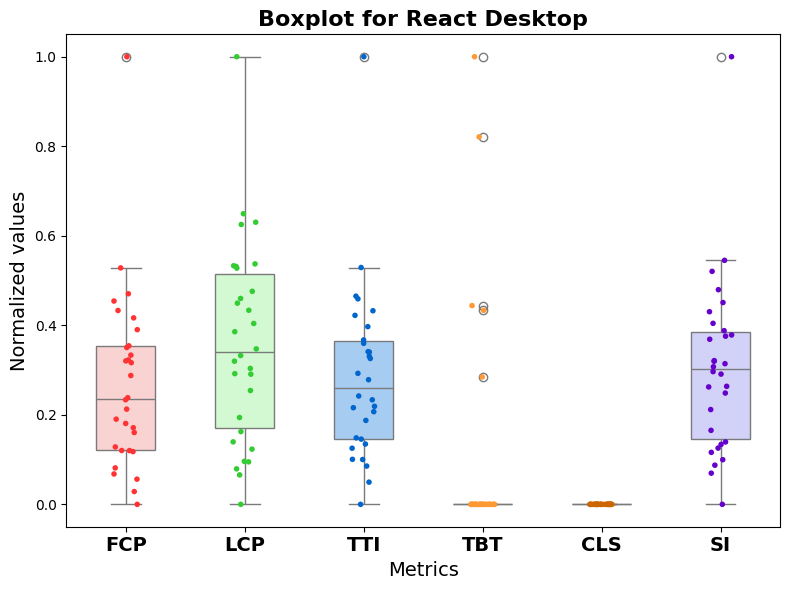

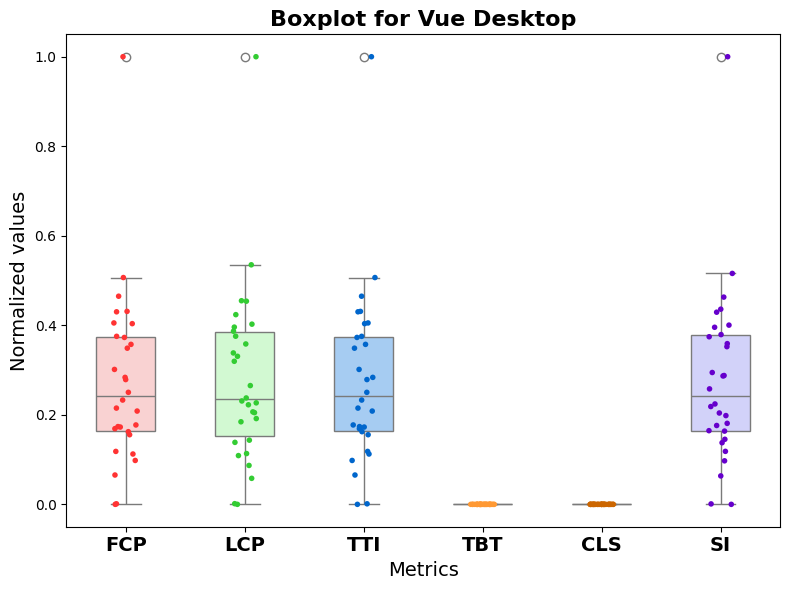

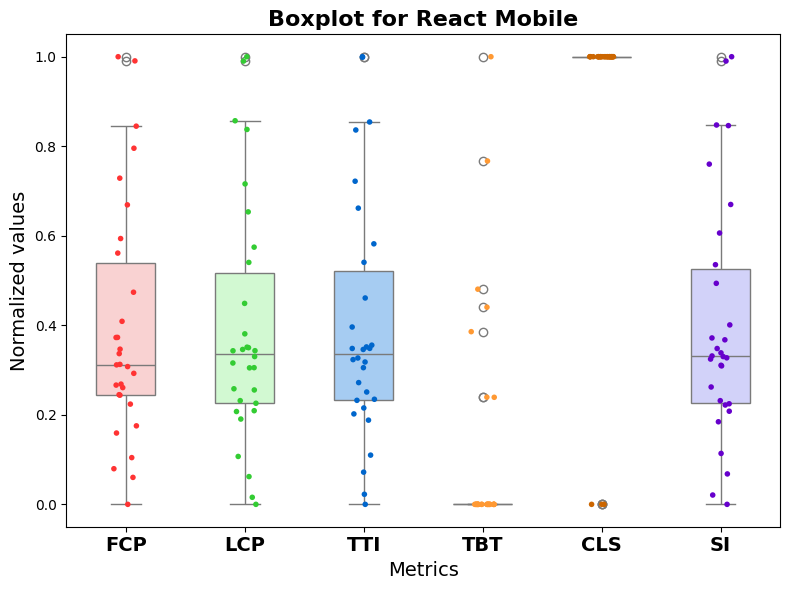

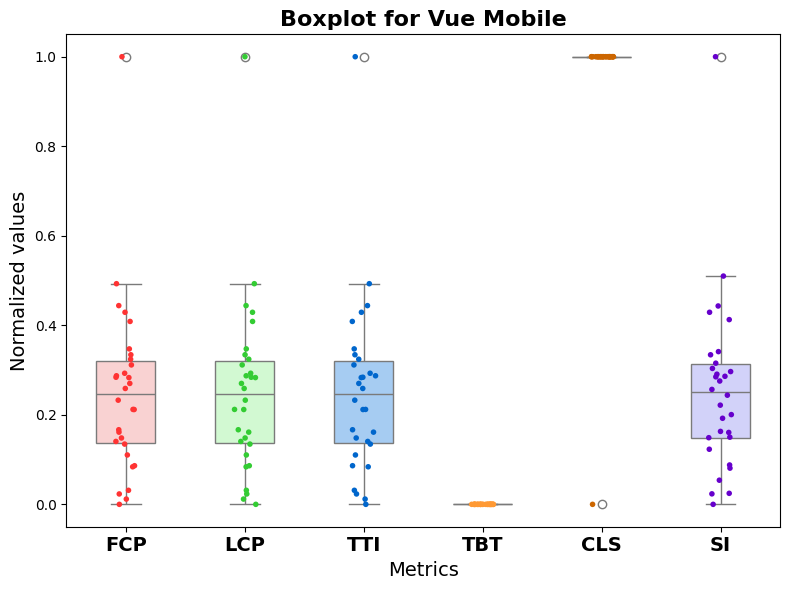

In [25]:

box_colors = ["#FFCCCC", "#CCFFCC", "#99CCFF", "#FFD9B3", "#FFC299", "#CCCCFF"]
strip_colors = ["#FF3333", "#33CC33", "#0066CC", "#FF9933", "#CC6600", "#6600CC"]

metrics_to_plot = ["FCP", "LCP", "TTI","TBT", "CLS", "SI"]

name_dict= {
    "react_desktop": "React Desktop",
    "vue_desktop": "Vue Desktop",
    "react_mobile": "React Mobile",
    "vue_mobile": "Vue Mobile"
}

# Plotting the boxplots for each DataFrame
for name, df in dataframes_normalized.items():
    df = df.rename(columns={
        "performance" : "Performance",
        "metrics.firstContentfulPaint": "FCP",
        "metrics.largestContentfulPaint": "LCP",
        "metrics.timeToInteractive": "TTI",
        "metrics.totalBlockingTime": "TBT",
        "metrics.cumulativeLayoutShift": "CLS",
        "metrics.speedIndex": "SI"
    })

    # Filter the DataFrame to include only the desired metrics
    df_filtered = df[metrics_to_plot]
    
    # Create a new figure for each dataset
    plt.figure(figsize=(8, 6))

    # Create the box plot with Seaborn
    sns.boxplot(data=df_filtered, palette=box_colors, width=0.5)
    sns.stripplot(data=df[metrics_to_plot], palette=strip_colors, alpha=1, size=4)
    
    # Set title and labels
    plt.title(f"Boxplot for {name_dict[name]}", fontsize=16, weight='bold')
    plt.xlabel("Metrics", fontsize=14)
    plt.ylabel("Normalized values", fontsize=14)
    
    plt.xticks(fontsize=14, fontweight="bold")

    # Show plot
    plt.tight_layout()
    plt.show()


In [26]:
for dataset_name, metrics_outliers in outliers.items():
    print(f"\nOutliers for {dataset_name}:\n")
    for metric, outlier_df in metrics_outliers.items():
        if not outlier_df.empty:
            print(f"\n  Outliers in {metric}:\n")
            print(tabulate(outlier_df, headers='keys', tablefmt='grid'))
        else:
            print(f"\n  No outliers in {metric}.")



Outliers for react_desktop:


  Outliers in metrics.firstContentfulPaint:

+----+---------------+--------------------------------+----------------------------------+-----------------------------+-----------------------------+---------------------------------+----------------------+
|    |   performance |   metrics.firstContentfulPaint |   metrics.largestContentfulPaint |   metrics.timeToInteractive |   metrics.totalBlockingTime |   metrics.cumulativeLayoutShift |   metrics.speedIndex |
+====+===============+================================+==================================+=============================+=============================+=================================+======================+
| 12 |          0.91 |                        1257.15 |                          1491.07 |                     1291.17 |                           0 |                     0.000138169 |                 1333 |
+----+---------------+--------------------------------+----------------------------------+--

In [27]:
outlier_df

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift,metrics.speedIndex
13,1,1401.696,1401.697,1401.696,0,0.001218,1445


In [28]:
output_file_with_outliers = "excel/dataframes_with_outliers_marked.xlsx"

def mark_outliers(df, outliers):
    df['is_outlier'] = False
    for metric, outlier_df in outliers.items():
        if not outlier_df.empty:
            df.loc[outlier_df.index, 'is_outlier'] = True   

    return df

dataframes_with_outliers_marked = {name: mark_outliers(df.copy(), outliers[name]) for name, df in dataframes.items()}

with pd.ExcelWriter(output_file_with_outliers) as writer:
    for dataset_name, df in dataframes_with_outliers_marked.items():
        df.to_excel(writer, sheet_name=dataset_name, index=True)

print(f"Dataframes with outliers marked saved to {output_file_with_outliers}")

Dataframes with outliers marked saved to excel/dataframes_with_outliers_marked.xlsx


In [29]:

# Statistics
def get_statistics(df):
    stats = df.describe().loc[["mean", "50%", "std"]].rename(index={"50%": "median"})
    return stats

statistics = {name: get_statistics(df) for name, df in dataframes.items()}


In [30]:
statistics["react_desktop"]

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift,metrics.speedIndex
mean,0.976667,737.393433,1023.396200,769.609967,0.755700,0.000138,823.400000
median,0.980000,713.488500,1010.227500,751.884000,0.000000,0.000138,822.000000
std,0.015610,141.359436,161.585661,139.959528,1.916105,0.000000,141.515833


In [31]:
for dataset_name, stats_df in statistics.items():
    print(f"\nStatistics for {dataset_name}:\n")
    print(stats_df)


Statistics for react_desktop:

        performance  metrics.firstContentfulPaint  \
mean       0.976667                    737.393433   
median     0.980000                    713.488500   
std        0.015610                    141.359436   

        metrics.largestContentfulPaint  metrics.timeToInteractive  \
mean                       1023.396200                 769.609967   
median                     1010.227500                 751.884000   
std                         161.585661                 139.959528   

        metrics.totalBlockingTime  metrics.cumulativeLayoutShift  \
mean                     0.755700                       0.000138   
median                   0.000000                       0.000138   
std                      1.916105                       0.000000   

        metrics.speedIndex  
mean            823.400000  
median          822.000000  
std             141.515833  

Statistics for vue_desktop:

        performance  metrics.firstContentfulPaint  \
mean  

In [32]:
output_file = "excel/statistics_output.xlsx"

with pd.ExcelWriter(output_file) as writer:
    for dataset_name, stats_df in statistics.items():
        stats_df.to_excel(writer, sheet_name=dataset_name)

print(f"Statistics saved to {output_file}")

Statistics saved to excel/statistics_output.xlsx


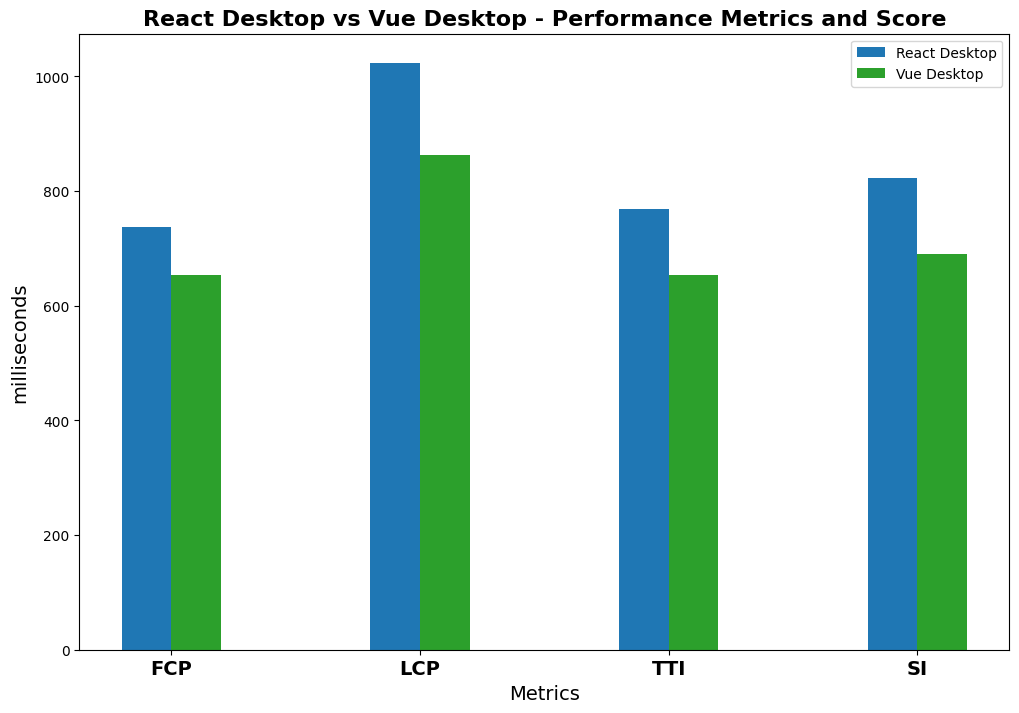

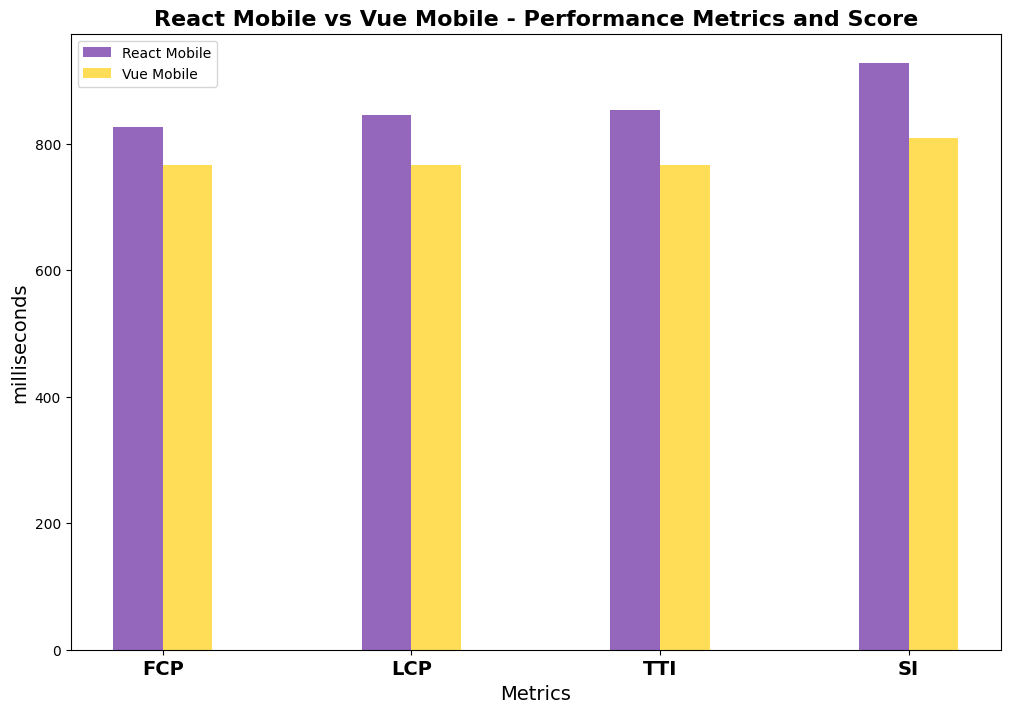

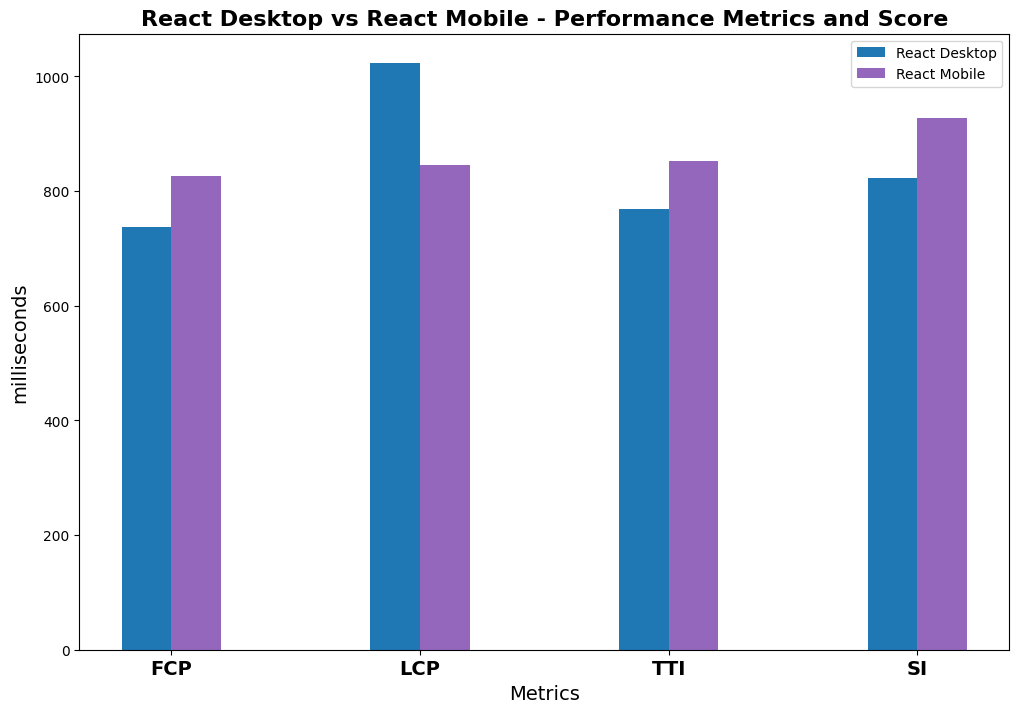

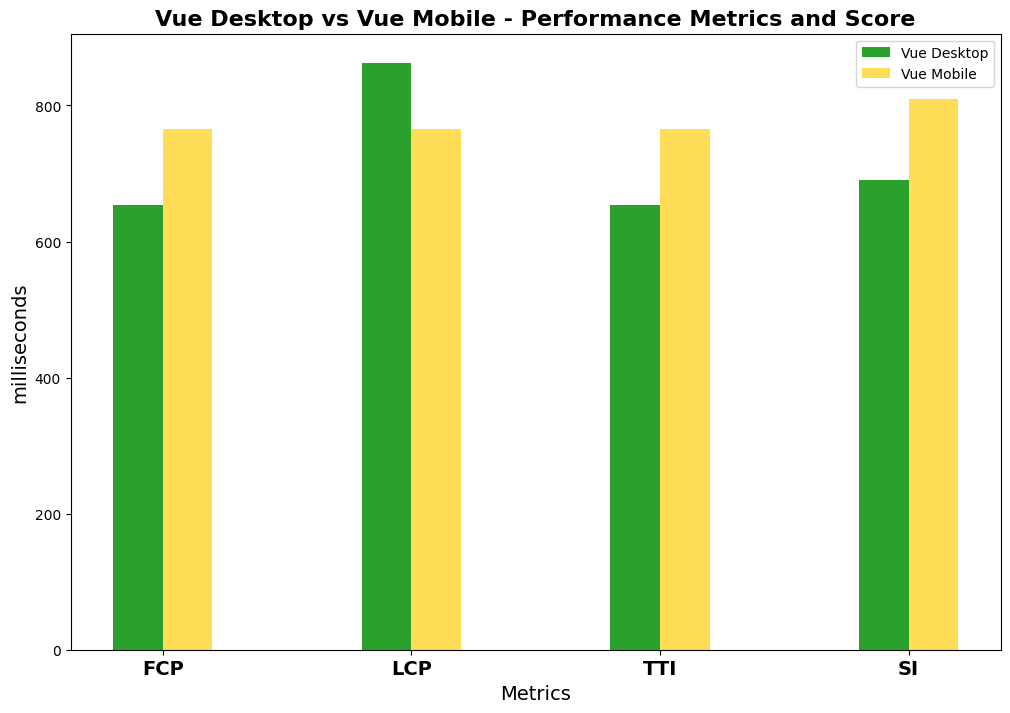

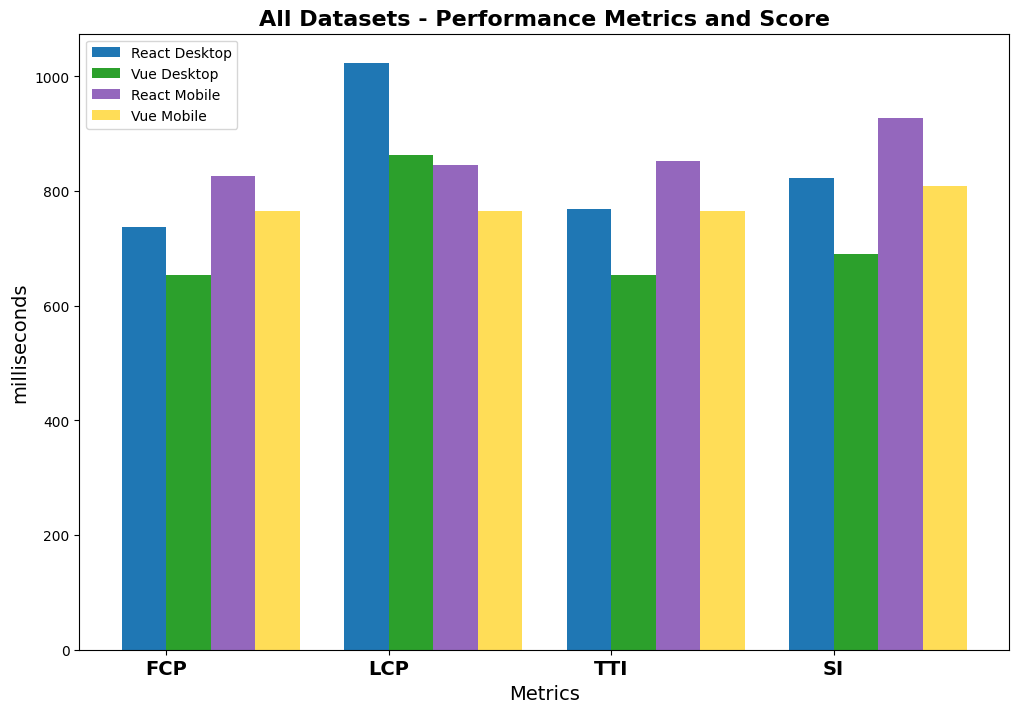

In [33]:
colors = {
    'React Desktop': '#1f77b4',       # Blue for React Desktop
    'Vue Desktop': '#2ca02c',         # Green for Vue Desktop
    'React Mobile': '#9467bd',        # Purple for React Mobile
    'Vue Mobile': '#ffdd57'           # Yellow for Vue Mobile
}

def rename_columns(df):
    return df.rename(columns={
        "performance": "Performance",
        "metrics.firstContentfulPaint": "FCP",
        "metrics.largestContentfulPaint": "LCP",
        "metrics.timeToInteractive": "TTI",
        "metrics.totalBlockingTime": "TBT",
        "metrics.cumulativeLayoutShift": "CLS",
        "metrics.speedIndex": "SI"
    })

def plot_grouped_bar(metrics, datasets, title):
    labels = list(datasets.keys())
    num_metrics = len(metrics)
    x = np.arange(len(metrics))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, (label, df) in enumerate(datasets.items()):

        df = rename_columns(df)

        means = [df.loc['mean', metric] for metric in metrics]
        ax.bar(x + i * width, means, width, label=label, color=colors[label])

    ax.set_xlabel('Metrics', fontsize=14)
    ax.set_ylabel('milliseconds', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(metrics, fontsize=14, fontweight="bold")
    ax.legend()

    plt.show()

metrics_to_compare = ["FCP", "LCP", "TTI", "SI"]

# React Desktop vs Vue Desktop
plot_grouped_bar(metrics_to_compare, {
    'React Desktop': statistics['react_desktop'],
    'Vue Desktop': statistics['vue_desktop']
}, 'React Desktop vs Vue Desktop - Performance Metrics and Score')

# React Mobile vs Vue Mobile
plot_grouped_bar(metrics_to_compare, {
    'React Mobile': statistics['react_mobile'],
    'Vue Mobile': statistics['vue_mobile']
}, 'React Mobile vs Vue Mobile - Performance Metrics and Score')

# React Desktop vs React Mobile
plot_grouped_bar(metrics_to_compare, {
    'React Desktop': statistics['react_desktop'],
    'React Mobile': statistics['react_mobile']
}, 'React Desktop vs React Mobile - Performance Metrics and Score')

# Vue Desktop vs Vue Mobile
plot_grouped_bar(metrics_to_compare, {
    'Vue Desktop': statistics['vue_desktop'],
    'Vue Mobile': statistics['vue_mobile']
}, 'Vue Desktop vs Vue Mobile - Performance Metrics and Score')

# All datasets
plot_grouped_bar(metrics_to_compare, {
    'React Desktop': statistics['react_desktop'],
    'Vue Desktop': statistics['vue_desktop'],
    'React Mobile': statistics['react_mobile'],
    'Vue Mobile': statistics['vue_mobile']
}, 'All Datasets - Performance Metrics and Score')




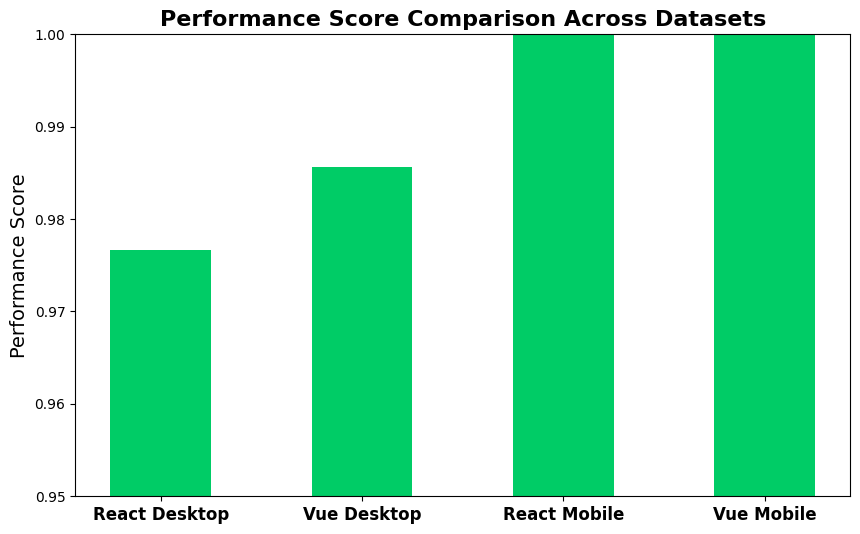

In [34]:
def plot_performance_comparison(datasets, title):
    labels = list(datasets.keys())
    performance_scores = [df.loc['mean', 'performance'] for df in datasets.values()]
    
    x = np.arange(len(labels)) 

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, performance_scores, width=0.5, color='#0c6')

    ax.set_xlabel("")
    ax.set_ylabel('Performance Score', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12, fontweight="bold")

    ax.set_ylim(0.95, 1)

    plt.show()


plot_performance_comparison({
    'React Desktop': statistics['react_desktop'],
    'Vue Desktop': statistics['vue_desktop'],
    'React Mobile': statistics['react_mobile'],
    'Vue Mobile': statistics['vue_mobile']
}, 'Performance Score Comparison Across Datasets')
